# Libraries

In [1]:
import pandas as pd
import os
import glob as gb
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2022-09-08 00:49:40.637091: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-09-08 00:49:40.637239: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# prepare data

In [2]:
def encode(s):
    names = {"buildings":0, "forest":1, "glacier":2, "mountain":3, "sea":4,"street":5}
    return names[s]

In [3]:
PATH = "../input/sprints-ai-and-ml-competition-2022/Scenes training set/Scenes training set/"
X = []
y = []
for folder in  os.listdir(PATH) : 
    files = gb.glob(pathname= str(PATH + folder + '/*.jpg'))
    for file in files: 
        img = cv2.imread(file)
        X.append(cv2.resize(img,(150,150)))
        y.append(encode(folder))

In [4]:
X = np.array(X)
y = np.array(y)
X.shape , y.shape

((14034, 150, 150, 3), (14034,))

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
# enable TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


2022-09-08 00:52:12.503458: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-08 00:52:12.506464: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-09-08 00:52:12.506504: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-08 00:52:12.506536: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (abea10bb50a2): /proc/driver/nvidia/version does not exist
2022-09-08 00:52:12.509947: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

# VGG16

0 input_10 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 global_average_pooling2d_8 True
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   

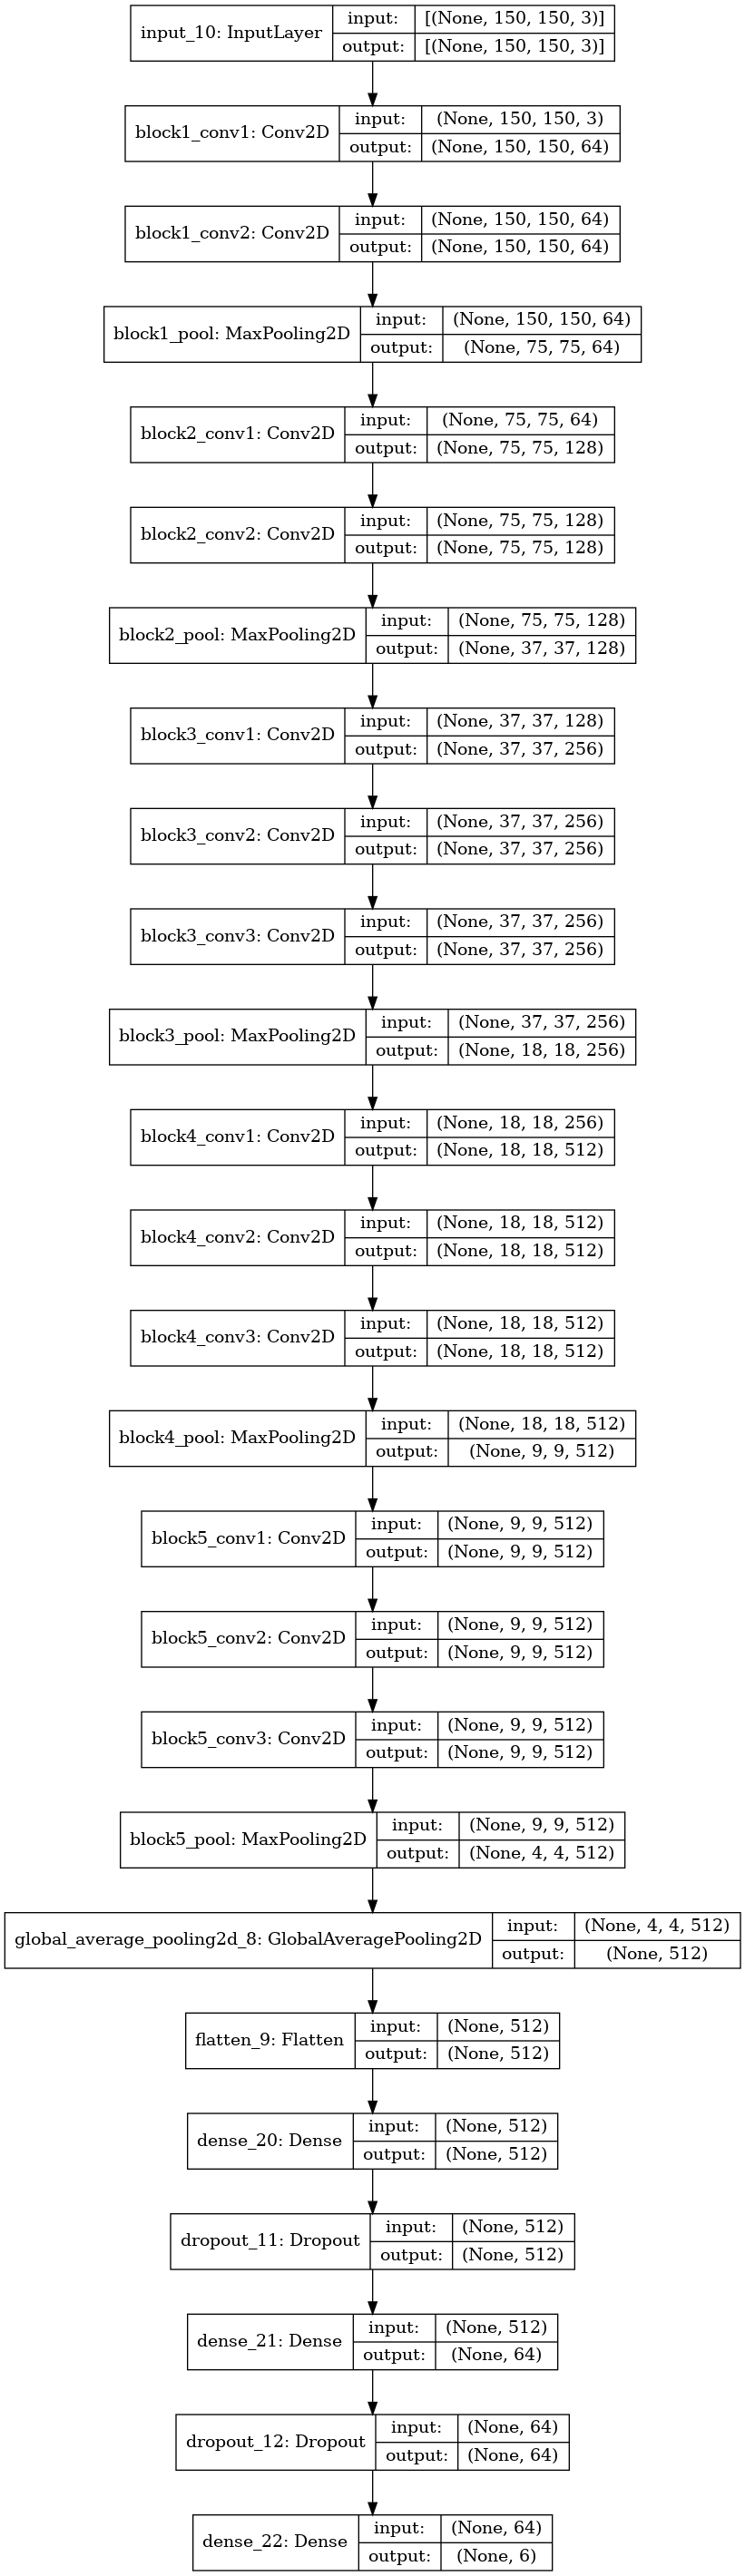

In [55]:
with tpu_strategy.scope():
    vggmodel = VGG16(input_shape=(150,150,3),pooling='avg',weights='imagenet', include_top=False)
    #freeze the first 3 blocks
    for layer in vggmodel.layers[:11]:
        layer.trainable = False
    for i, layer in enumerate(vggmodel.layers):
        print(i, layer.name, layer.trainable)

    top_model = vggmodel.output
    top_model = Layers.Flatten()(top_model)
    top_model = Layers.Dense(512, activation='relu')(top_model)
    top_model = Layers.Dropout(0.5)(top_model)
    top_model = Layers.Dense(64, activation='relu')(top_model)
    top_model = Layers.Dropout(0.2)(top_model)


    output_layer = Layers.Dense(6, activation='softmax')(top_model)
    vggmodel = Models.Model(inputs=vggmodel.input, outputs=output_layer)
    vggmodel.compile(optimizer=Optimizer.Adam(0.000005),loss='sparse_categorical_crossentropy' ,metrics=['accuracy'])
vggmodel.summary()
Utils.plot_model(vggmodel,to_file='model.png',show_shapes=True)

In [88]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5,verbose=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
trained2 = vggmodel.fit(X_train,y_train,validation_split=0.3,epochs=100,callbacks=[reduce_lr,es],batch_size=128)

Epoch 1/100
62/62 [==============================] - 35s 378ms/step - loss: 4.4112 - accuracy: 0.2373 - val_loss: 1.4586 - val_accuracy: 0.4752
Epoch 2/100
62/62 [==============================] - 3s 43ms/step - loss: 1.7230 - accuracy: 0.3256 - val_loss: 1.2536 - val_accuracy: 0.5987
Epoch 3/100
62/62 [==============================] - 3s 44ms/step - loss: 1.4749 - accuracy: 0.4214 - val_loss: 1.0178 - val_accuracy: 0.6696
Epoch 4/100
62/62 [==============================] - 3s 42ms/step - loss: 1.2644 - accuracy: 0.5121 - val_loss: 0.7874 - val_accuracy: 0.7519
Epoch 5/100
62/62 [==============================] - 3s 42ms/step - loss: 1.0281 - accuracy: 0.6135 - val_loss: 0.5931 - val_accuracy: 0.8231
Epoch 6/100
62/62 [==============================] - 3s 43ms/step - loss: 0.8430 - accuracy: 0.6961 - val_loss: 0.4778 - val_accuracy: 0.8560
Epoch 7/100
62/62 [==============================] - 3s 55ms/step - loss: 0.7216 - accuracy: 0.7458 - val_loss: 0.4028 - val_accuracy: 0.8753
Epoc

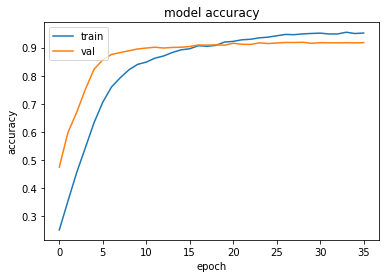

In [89]:
# summarize history for accuracy
plt.plot(trained2.history['accuracy'])
plt.plot(trained2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

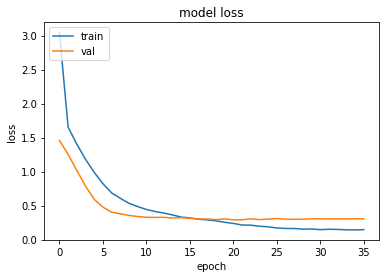

In [90]:
# summarize history for loss
plt.plot(trained2.history['loss'])
plt.plot(trained2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [91]:
ModelLoss, ModelAccuracy = vggmodel.evaluate(X_test, y_test)
print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

88/88 [==============================] - 15s 115ms/step - loss: 0.2915 - accuracy: 0.9234
Test Loss is 0.29153430461883545
Test Accuracy is 0.9234057664871216


# ResNet50

In [105]:
with tpu_strategy.scope():
    from tensorflow.keras.applications.resnet50 import ResNet50
    resmodel = ResNet50(input_shape=(150,150,3),pooling = 'avg',weights='imagenet', include_top=False)
    for layer in resmodel.layers[:-18]:
        layer.trainable = False
    for i, layer in enumerate(resmodel.layers):
        print(i, layer.name, layer.trainable)

    top_model = resmodel.output
    top_model = Layers.Flatten()(top_model)
    top_model = Layers.Dense(512, activation='relu')(top_model)
    top_model = Layers.Dropout(0.5)(top_model)
    top_model = Layers.Dense(64, activation='relu')(top_model)
    top_model = Layers.Dropout(0.2)(top_model)
    output_layer = Layers.Dense(6, activation='softmax')(top_model)

    resmodel = Models.Model(inputs=resmodel.input, outputs=output_layer)
    resmodel.compile(optimizer=Optimizer.Adam(lr=0.000003),loss='sparse_categorical_crossentropy' ,metrics=['accuracy'])
resmodel.summary()

0 input_12 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_blo

In [106]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5,verbose=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
trained3 = resmodel.fit(X_train,y_train,validation_split=0.3,epochs=100,callbacks=[reduce_lr,es],batch_size=128)

Epoch 1/100
62/62 [==============================] - 36s 352ms/step - loss: 2.5362 - accuracy: 0.1736 - val_loss: 1.8540 - val_accuracy: 0.2906
Epoch 2/100
62/62 [==============================] - 3s 42ms/step - loss: 2.0797 - accuracy: 0.2488 - val_loss: 1.4881 - val_accuracy: 0.4366
Epoch 3/100
62/62 [==============================] - 2s 41ms/step - loss: 1.8005 - accuracy: 0.3223 - val_loss: 1.2512 - val_accuracy: 0.5367
Epoch 4/100
62/62 [==============================] - 3s 41ms/step - loss: 1.5917 - accuracy: 0.3876 - val_loss: 1.0820 - val_accuracy: 0.6180
Epoch 5/100
62/62 [==============================] - 3s 41ms/step - loss: 1.4032 - accuracy: 0.4607 - val_loss: 0.9508 - val_accuracy: 0.6943
Epoch 6/100
62/62 [==============================] - 3s 41ms/step - loss: 1.2652 - accuracy: 0.5124 - val_loss: 0.8415 - val_accuracy: 0.7516
Epoch 7/100
62/62 [==============================] - 3s 41ms/step - loss: 1.1394 - accuracy: 0.5671 - val_loss: 0.7454 - val_accuracy: 0.7982
Epoc

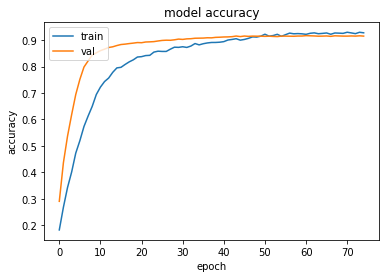

In [107]:
# summarize history for accuracy
plt.plot(trained3.history['accuracy'])
plt.plot(trained3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

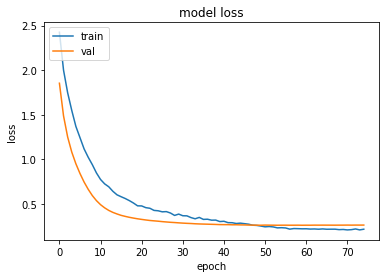

In [108]:
# summarize history for loss
plt.plot(trained3.history['loss'])
plt.plot(trained3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [109]:
ModelLoss, ModelAccuracy = resmodel.evaluate(X_test, y_test)
print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

88/88 [==============================] - 13s 94ms/step - loss: 0.2267 - accuracy: 0.9241
Test Loss is 0.2267184853553772
Test Accuracy is 0.9241182804107666


# EfficientNetB0

In [193]:
with tpu_strategy.scope():
    from tensorflow.keras.applications import EfficientNetB0
    efficientnetmodel = EfficientNetB0(input_shape=(150,150,3),pooling = 'avg',weights='imagenet', include_top=False)
    for layer in efficientnetmodel.layers[:221]:
        layer.trainable = False
    for i, layer in enumerate(efficientnetmodel.layers):
        print(i, layer.name, layer.trainable)

    top_model = efficientnetmodel.output
    top_model = Layers.Flatten()(top_model)
    top_model = Layers.Dense(512, activation='relu')(top_model)
    top_model = Layers.Dropout(0.5)(top_model)
    top_model = Layers.Dense(64, activation='relu')(top_model)
    top_model = Layers.Dropout(0.2)(top_model)
    output_layer = Layers.Dense(6, activation='softmax')(top_model)

    efficientnetmodel = Models.Model(inputs=efficientnetmodel.input, outputs=output_layer)
    efficientnetmodel.compile(optimizer=Optimizer.Adam(lr=0.00001),loss='sparse_categorical_crossentropy' ,metrics=['accuracy'])
efficientnetmodel.summary()

0 input_23 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resh

In [194]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5,verbose=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
trained4 = efficientnetmodel.fit(X_train,y_train,validation_split=0.3,epochs=100,callbacks=[reduce_lr,es],batch_size=128)

Epoch 1/100
62/62 [==============================] - 35s 285ms/step - loss: 1.8426 - accuracy: 0.1913 - val_loss: 1.5922 - val_accuracy: 0.4316
Epoch 2/100
62/62 [==============================] - 3s 45ms/step - loss: 1.6535 - accuracy: 0.3281 - val_loss: 1.4069 - val_accuracy: 0.5785
Epoch 3/100
62/62 [==============================] - 3s 45ms/step - loss: 1.4988 - accuracy: 0.4434 - val_loss: 1.2273 - val_accuracy: 0.6684
Epoch 4/100
62/62 [==============================] - 3s 45ms/step - loss: 1.3370 - accuracy: 0.5469 - val_loss: 1.0651 - val_accuracy: 0.7296
Epoch 5/100
62/62 [==============================] - 3s 45ms/step - loss: 1.1935 - accuracy: 0.6097 - val_loss: 0.9258 - val_accuracy: 0.7682
Epoch 6/100
62/62 [==============================] - 3s 45ms/step - loss: 1.0709 - accuracy: 0.6616 - val_loss: 0.8083 - val_accuracy: 0.7970
Epoch 7/100
62/62 [==============================] - 3s 45ms/step - loss: 0.9635 - accuracy: 0.6966 - val_loss: 0.7130 - val_accuracy: 0.8219
Epoc

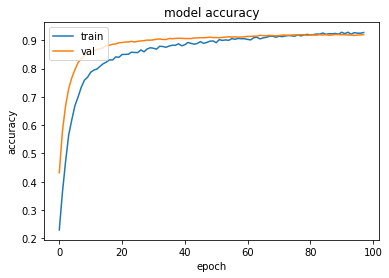

In [195]:
# summarize history for accuracy
plt.plot(trained4.history['accuracy'])
plt.plot(trained4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

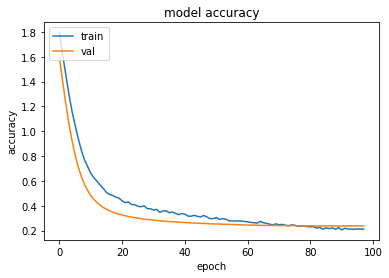

In [196]:
# summarize history for accuracy
plt.plot(trained4.history['loss'])
plt.plot(trained4.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [197]:
ModelLoss, ModelAccuracy = efficientnetmodel.evaluate(X_test, y_test)
print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

88/88 [==============================] - 10s 64ms/step - loss: 0.2146 - accuracy: 0.9266
Test Loss is 0.21455805003643036
Test Accuracy is 0.9266120195388794


# ResNet101

In [156]:
with tpu_strategy.scope():
    from tensorflow.keras.applications.resnet import ResNet101
    res101model = ResNet101(input_shape=(150,150,3),pooling = 'avg',weights='imagenet', include_top=False)
    for layer in res101model.layers[:335]:
        layer.trainable = False
    for i, layer in enumerate(res101model.layers):
        print(i, layer.name, layer.trainable)

    top_model = res101model.output
    top_model = Layers.Flatten()(top_model)
    top_model = Layers.Dense(512, activation='relu')(top_model)
    top_model = Layers.Dropout(0.5)(top_model)
    top_model = Layers.Dense(128, activation='relu')(top_model)
    top_model = Layers.Dropout(0.2)(top_model)
    output_layer = Layers.Dense(6, activation='softmax')(top_model)

    res101model = Models.Model(inputs=res101model.input, outputs=output_layer)
    res101model.compile(optimizer=Optimizer.Adam(lr=0.000003),loss='sparse_categorical_crossentropy' ,metrics=['accuracy'])
#res101model.summary()

0 input_18 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_blo

In [157]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5,verbose=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
trained5 = res101model.fit(X_train,y_train,validation_split=0.3,epochs=100,callbacks=[reduce_lr,es],batch_size=128)

Epoch 1/100
62/62 [==============================] - 48s 439ms/step - loss: 2.7449 - accuracy: 0.1665 - val_loss: 1.8328 - val_accuracy: 0.2642
Epoch 2/100
62/62 [==============================] - 4s 59ms/step - loss: 2.2571 - accuracy: 0.2155 - val_loss: 1.4382 - val_accuracy: 0.4512
Epoch 3/100
62/62 [==============================] - 4s 58ms/step - loss: 1.9075 - accuracy: 0.3007 - val_loss: 1.1951 - val_accuracy: 0.5785
Epoch 4/100
62/62 [==============================] - 4s 58ms/step - loss: 1.6483 - accuracy: 0.3806 - val_loss: 1.0239 - val_accuracy: 0.6655
Epoch 5/100
62/62 [==============================] - 4s 59ms/step - loss: 1.4477 - accuracy: 0.4551 - val_loss: 0.8932 - val_accuracy: 0.7148
Epoch 6/100
62/62 [==============================] - 4s 58ms/step - loss: 1.3095 - accuracy: 0.5061 - val_loss: 0.7884 - val_accuracy: 0.7584
Epoch 7/100
62/62 [==============================] - 4s 59ms/step - loss: 1.2216 - accuracy: 0.5437 - val_loss: 0.7048 - val_accuracy: 0.7821
Epoc

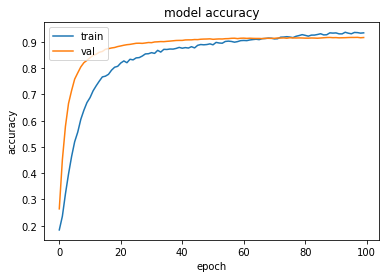

In [160]:
# summarize history for accuracy
plt.plot(trained5.history['accuracy'])
plt.plot(trained5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

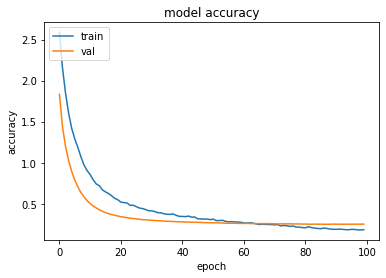

In [161]:
# summarize history for accuracy
plt.plot(trained5.history['loss'])
plt.plot(trained5.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [162]:
ModelLoss, ModelAccuracy = res101model.evaluate(X_test, y_test)
print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

88/88 [==============================] - 16s 117ms/step - loss: 0.2438 - accuracy: 0.9216
Test Loss is 0.24384887516498566
Test Accuracy is 0.921624481678009


# Print all accuracies

In [198]:
for m in [vggmodel,resmodel,efficientnetmodel,res101model]:
    predicts = np.argmax(m.predict(X_test), axis=1)
    print(np.mean((y_test==predicts)))

0.9234057712860705
0.9241182757392233
0.9266120413252583
0.9216245101531885


# Hard-Vote Ensemble

In [199]:
results_test = []
for m in [vggmodel,resmodel,efficientnetmodel,res101model]:
    predicts = np.argmax(m.predict(X_test), axis=1)
    results_test.append(predicts)

In [200]:
from scipy import stats
results_test = np.array(results_test)
results_test = np.transpose(results_test,(1,0))
results_test = stats.mode(results_test, axis=1)[0]
results_test =  np.squeeze(results_test)

In [201]:
np.mean((y_test==results_test))

0.934093338083363

# Average-Ensemble

In [202]:
model_input = tf.keras.Input(shape=(150, 150, 3))
model_outputs = [model(model_input) for model in [vggmodel,resmodel,efficientnetmodel,res101model]]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
model_9 (Functional)            (None, 6)            15010566    input_24[0][0]                   
__________________________________________________________________________________________________
model_11 (Functional)           (None, 6)            24670022    input_24[0][0]                   
__________________________________________________________________________________________________
model_20 (Functional)           (None, 6)            4738665     input_24[0][0]                   
___________________________________________________________________________________________

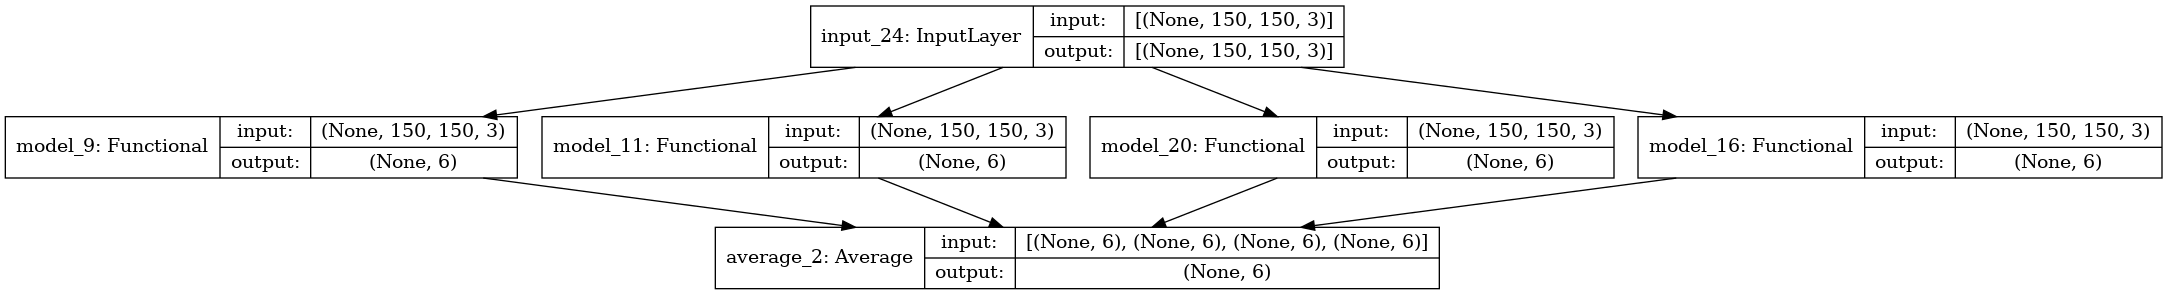

In [203]:
ensemble_model.summary()
Utils.plot_model(ensemble_model,show_shapes=True)

In [204]:
e = ensemble_model.predict(X_test)

In [206]:
np.mean((y_test==np.argmax(e,axis=1)))

0.93836836480228

### we have decided to use Average-Ensemble due to its high accuracy

# Predict Test set and submit

In [56]:
Test_Path = "../input/sprints-ai-and-ml-competition-2022/Scenes testing test/Scenes testing test/"
test = []
files = gb.glob(pathname= str(Test_Path + '*.jpg'))
images_names = []
for file in files: 
    images_names.append(os.path.basename(file))
    img = cv2.imread(file)
    test.append(cv2.resize(img,(150,150)))
test = np.array(test)
test.shape

(3050, 150, 150, 3)

In [215]:
labels = ensemble_model.predict(test)

In [217]:
submit = pd.read_csv('../input/sprints-ai-and-ml-competition-2022/submit.csv')
submit['Image'] = images_names
submit['Label'] = np.argmax(labels,axis=1)

In [227]:
submit.to_csv("submit6.csv", encoding='utf-8', index=False)